In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
import os
plt.rcParams['figure.facecolor'] = 'white'

from numba import jit
import scipy

In [44]:
def sgolay2d ( z, window_size, order, derivative=None):
    """
    """
    # number of terms in the polynomial expression
    n_terms = ( order + 1 ) * ( order + 2)  / 2.0

    if  window_size % 2 == 0:
        window_size+=1

    if window_size**2 < n_terms:
        raise ValueError('order is too high for the window size')

    half_size = window_size // 2

    # exponents of the polynomial.
    # p(x,y) = a0 + a1*x + a2*y + a3*x^2 + a4*y^2 + a5*x*y + ...
    # this line gives a list of two item tuple. Each tuple contains
    # the exponents of the k-th term. First element of tuple is for x
    # second element for y.
    # Ex. exps = [(0,0), (1,0), (0,1), (2,0), (1,1), (0,2), ...]
    exps = [ (k-n, n) for k in range(order+1) for n in range(k+1) ]

    # coordinates of points
    ind = np.arange(-half_size, half_size+1, dtype=np.float64)
    dx = np.repeat( ind, window_size )
    dy = np.tile( ind, [window_size, 1]).reshape(window_size**2, )

    # build matrix of system of equation
    A = np.empty( (window_size**2, len(exps)) )
    for i, exp in enumerate( exps ):
        A[:,i] = (dx**exp[0]) * (dy**exp[1])

    # pad input array with appropriate values at the four borders
    new_shape = z.shape[0] + 2*half_size, z.shape[1] + 2*half_size
    Z = np.zeros( (new_shape) )
    # top band
    band = z[0, :]
    Z[:half_size, half_size:-half_size] =  band -  np.abs( np.flipud( z[1:half_size+1, :] ) - band )
    # bottom band
    band = z[-1, :]
    Z[-half_size:, half_size:-half_size] = band  + np.abs( np.flipud( z[-half_size-1:-1, :] )  -band )
    # left band
    band = np.tile( z[:,0].reshape(-1,1), [1,half_size])
    Z[half_size:-half_size, :half_size] = band - np.abs( np.fliplr( z[:, 1:half_size+1] ) - band )
    # right band
    band = np.tile( z[:,-1].reshape(-1,1), [1,half_size] )
    Z[half_size:-half_size, -half_size:] =  band + np.abs( np.fliplr( z[:, -half_size-1:-1] ) - band )
    # central band
    Z[half_size:-half_size, half_size:-half_size] = z

    # top left corner
    band = z[0,0]
    Z[:half_size,:half_size] = band - np.abs( np.flipud(np.fliplr(z[1:half_size+1,1:half_size+1]) ) - band )
    # bottom right corner
    band = z[-1,-1]
    Z[-half_size:,-half_size:] = band + np.abs( np.flipud(np.fliplr(z[-half_size-1:-1,-half_size-1:-1]) ) - band )

    # top right corner
    band = Z[half_size,-half_size:]
    Z[:half_size,-half_size:] = band - np.abs( np.flipud(Z[half_size+1:2*half_size+1,-half_size:]) - band )
    # bottom left corner
    band = Z[-half_size:,half_size].reshape(-1,1)
    Z[-half_size:,:half_size] = band - np.abs( np.fliplr(Z[-half_size:, half_size+1:2*half_size+1]) - band )

    # solve system and convolve
    if derivative == None:
        m = np.linalg.pinv(A)[0].reshape((window_size, -1))
        return scipy.signal.fftconvolve(Z, m, mode='valid')
    elif derivative == 'col':
        c = np.linalg.pinv(A)[1].reshape((window_size, -1))
        return scipy.signal.fftconvolve(Z, -c, mode='valid')
    elif derivative == 'row':
        r = np.linalg.pinv(A)[2].reshape((window_size, -1))
        return scipy.signal.fftconvolve(Z, -r, mode='valid')
    elif derivative == 'both':
        c = np.linalg.pinv(A)[1].reshape((window_size, -1))
        r = np.linalg.pinv(A)[2].reshape((window_size, -1))
        return scipy.signal.fftconvolve(Z, -r, mode='valid'), scipy.signal.fftconvolve(Z, -c, mode='valid')

In [173]:
def gather_universal(path: str,filetype: str)-> list:
    subdir=path

    data=[]
    for path, subdirs, files in os.walk(subdir):
        for name in files:
            if name.endswith(filetype) and name[-5]!='t'  :

                b=(str(os.path.join(path, name)))
                data.append(b)

                #print (str(os.path.join(path, name)))
    return data
def sort_on_last(list:list)->list:
    df=pd.DataFrame({'list': list})
    df['nums']=df['list'].apply(lambda x:x.split('_')[-1].split('.')[0])
    df['nums']=df.nums.astype(int)
    df.sort_values(by='nums',inplace=True)
    #display(df)
    return(np.array(df['list']))
@jit(nopython=True)
def clean_file(file):
        for num,line in enumerate(file):

            a=line.replace(',','.')
            a=a.replace('e-00','e-')
            a=a.replace('e-0','e-')
            a=a.replace('\n','')
            a=a.replace('\t\t\t\t','\t\t')
            file[num]=a


        return file
@jit(nopython=True)
def get_col_unit(file):
        cols=file[1].split('\t')
        units=file[2].split('\t')

        col_unit=[]
        for i,v in enumerate(cols):
            col_unit.append(v+' ['+units[i]+']')
        return(col_unit)
@jit(nopython=False)
def split_file(file,col_unit):
        splitfile=np.array(col_unit)
        for line in np.arange(3,len(file)):
            a=np.array(file[line].split('\t'),dtype=str)
            splitfile=np.vstack((splitfile,a))
        return(splitfile)
@jit(nopython=True)
def get_file(path)->list:

        file=[]
        with open(path, 'r') as reader:
             # Read and print the entire file line by line
            for line in reader:
                file.append(line)
        return(file)
def get_force(path):
    with open(path, 'r') as reader:
        lines=reader.readlines()[:4]

        #head = [next(reader) for x in range(4)]
        #display(head)


        #display(lines[3])
        force=lines[3].split('\t')[-2].split('\n')[0].replace(',','.')
        return float(force)

def get_header(path)->list:
    with open(path, 'r') as reader:
        lines=reader.readlines()
        cleanline1=lines[1].replace('\n','').replace('\t\t\t\t','\t').split('\t')
        cleanline2=lines[2].replace('\n','').replace('\t\t\t\t','\t').split('\t')
        #display(len(cleanline2),len(cleanline1))
        col_unit=[]
        for i,v in enumerate(cleanline1):
            col_unit.append(v+' ['+cleanline2[i]+']')
        #display(col_unit)
        return(col_unit[:])

#get_header('data/MC_A6yii/Step_149.txt')
def manual_input(path:str)->pd.DataFrame:

    file=get_file(path)        #print(line, end='')
    file=clean_file(file)

    col_unit=get_col_unit(file)

    splitfile=split_file(file,col_unit)
    df=pd.DataFrame(data=splitfile[1:,:],columns=splitfile[0,:])
    display(df)
    df[df=='']=np.nan
    df=df.astype(np.float64)
    #%%
    display(df.columns)

    f=df.loc[:,['x []','y []','strains [strain_p1/strain]']]
    b=f.pivot(index='y []',columns='x []',values='strains [strain_p1/strain]')
    display(b)
    #%%
    plt.matshow(b)

In [174]:
def cleaner(filepath,exportnames):
    fin = open(filepath, "rt")
    #read file contents to string
    data = fin.read()
    #replace all occurrences of the required string
    data = data.replace('\t\t\t\t', '\t\t')
    data = data.replace('e-00', 'e-')
    data = data.replace('e-0', 'e-')
    data = data.replace('e+00', 'e+')
    data = data.replace('e+0', 'e+')
    data = data.replace('.', '')
    data = data.replace(',', '.')
    #close the input file
    fin.close()
    #open the input file in write mode
    fin = open(exportnames[filepath], "wt")
    #overrite the input file with the resulting data
    fin.write(data)
    #close the file
    fin.close()
def auto_input(path:str)->pd.DataFrame:

    df=pd.read_csv(path,header=None,skiprows=range(3),sep='\t',decimal='.',encoding='utf-8')

    df.columns=get_header(path)
    df.set_index(['x []','y []'],inplace=True)

    #display(df)
    return df


In [175]:
def get_p1(df):
    p1=df['strains [true_strain_p1/strain]'].reset_index().pivot(index='x []',columns='y []',values='strains [true_strain_p1/strain]').copy()
    return(p1)
def meanofslice(df):
    horizontalcount=10
    horizontalsize=int(len(df.columns)/horizontalcount)
    verticalsize=len(df.index)
    #display(horizontalsize,verticalsize)
    res=np.zeros(horizontalcount)
    #display(res)
    for i in range(horizontalcount):
        start=i*horizontalsize
        end=((i*horizontalsize)+horizontalsize)
        res[i]=np.nanmean(np.array(df.iloc[:,start:end]))
        #display(res[i])
        #display(i,df.iloc[:,start:end])
        #res[i]=np.mean(df.iloc[:,start:end])
    return(res)


In [225]:
names=sort_on_last(gather_universal('data/MC_B_6xii','.txt'))
def amend_export(string):
    return string.split('.')[0]+'_export.txt'
#display(names)
exportnames={i:amend_export(i) for i in names}
#display(exportnames)

res=[]
force=[]
for name in names:
    force.append(get_force(name))
    #display(get_force(name))
    cleaner(name,exportnames)
    df=auto_input(exportnames[name])
    display(exportnames[name])
    p1=get_p1(df)
    meanarr=meanofslice(p1)
    res.append(meanarr)

ap=pd.DataFrame(res)
display(ap)
#display(force)

'data/MC_B_6xii\\Step_0_export.txt'

'data/MC_B_6xii\\Step_1_export.txt'

'data/MC_B_6xii\\Step_2_export.txt'

'data/MC_B_6xii\\Step_3_export.txt'

'data/MC_B_6xii\\Step_4_export.txt'

'data/MC_B_6xii\\Step_5_export.txt'

'data/MC_B_6xii\\Step_6_export.txt'

'data/MC_B_6xii\\Step_7_export.txt'

'data/MC_B_6xii\\Step_8_export.txt'

'data/MC_B_6xii\\Step_9_export.txt'

'data/MC_B_6xii\\Step_10_export.txt'

'data/MC_B_6xii\\Step_11_export.txt'

'data/MC_B_6xii\\Step_12_export.txt'

'data/MC_B_6xii\\Step_13_export.txt'

'data/MC_B_6xii\\Step_14_export.txt'

'data/MC_B_6xii\\Step_15_export.txt'

'data/MC_B_6xii\\Step_16_export.txt'

'data/MC_B_6xii\\Step_17_export.txt'

'data/MC_B_6xii\\Step_18_export.txt'

'data/MC_B_6xii\\Step_19_export.txt'

'data/MC_B_6xii\\Step_20_export.txt'

'data/MC_B_6xii\\Step_21_export.txt'

'data/MC_B_6xii\\Step_22_export.txt'

'data/MC_B_6xii\\Step_23_export.txt'

'data/MC_B_6xii\\Step_24_export.txt'

'data/MC_B_6xii\\Step_25_export.txt'

'data/MC_B_6xii\\Step_26_export.txt'

'data/MC_B_6xii\\Step_27_export.txt'

'data/MC_B_6xii\\Step_28_export.txt'

'data/MC_B_6xii\\Step_29_export.txt'

'data/MC_B_6xii\\Step_30_export.txt'

'data/MC_B_6xii\\Step_31_export.txt'

'data/MC_B_6xii\\Step_32_export.txt'

'data/MC_B_6xii\\Step_33_export.txt'

'data/MC_B_6xii\\Step_34_export.txt'

'data/MC_B_6xii\\Step_35_export.txt'

'data/MC_B_6xii\\Step_36_export.txt'

'data/MC_B_6xii\\Step_37_export.txt'

'data/MC_B_6xii\\Step_38_export.txt'

'data/MC_B_6xii\\Step_39_export.txt'

'data/MC_B_6xii\\Step_40_export.txt'

'data/MC_B_6xii\\Step_41_export.txt'

'data/MC_B_6xii\\Step_42_export.txt'

'data/MC_B_6xii\\Step_43_export.txt'

'data/MC_B_6xii\\Step_44_export.txt'

'data/MC_B_6xii\\Step_45_export.txt'

'data/MC_B_6xii\\Step_46_export.txt'

'data/MC_B_6xii\\Step_47_export.txt'

'data/MC_B_6xii\\Step_48_export.txt'

'data/MC_B_6xii\\Step_49_export.txt'

'data/MC_B_6xii\\Step_50_export.txt'

'data/MC_B_6xii\\Step_51_export.txt'

'data/MC_B_6xii\\Step_52_export.txt'

'data/MC_B_6xii\\Step_53_export.txt'

'data/MC_B_6xii\\Step_54_export.txt'

'data/MC_B_6xii\\Step_55_export.txt'

'data/MC_B_6xii\\Step_56_export.txt'

'data/MC_B_6xii\\Step_57_export.txt'

'data/MC_B_6xii\\Step_58_export.txt'

'data/MC_B_6xii\\Step_59_export.txt'

'data/MC_B_6xii\\Step_60_export.txt'

'data/MC_B_6xii\\Step_61_export.txt'

'data/MC_B_6xii\\Step_62_export.txt'

'data/MC_B_6xii\\Step_63_export.txt'

'data/MC_B_6xii\\Step_64_export.txt'

'data/MC_B_6xii\\Step_65_export.txt'

'data/MC_B_6xii\\Step_66_export.txt'

'data/MC_B_6xii\\Step_67_export.txt'

'data/MC_B_6xii\\Step_68_export.txt'

'data/MC_B_6xii\\Step_69_export.txt'

'data/MC_B_6xii\\Step_70_export.txt'

'data/MC_B_6xii\\Step_71_export.txt'

'data/MC_B_6xii\\Step_72_export.txt'

'data/MC_B_6xii\\Step_73_export.txt'

'data/MC_B_6xii\\Step_74_export.txt'

'data/MC_B_6xii\\Step_75_export.txt'

'data/MC_B_6xii\\Step_76_export.txt'

'data/MC_B_6xii\\Step_77_export.txt'

'data/MC_B_6xii\\Step_78_export.txt'

'data/MC_B_6xii\\Step_79_export.txt'

'data/MC_B_6xii\\Step_80_export.txt'

'data/MC_B_6xii\\Step_81_export.txt'

'data/MC_B_6xii\\Step_82_export.txt'

'data/MC_B_6xii\\Step_83_export.txt'

'data/MC_B_6xii\\Step_84_export.txt'

'data/MC_B_6xii\\Step_85_export.txt'

'data/MC_B_6xii\\Step_86_export.txt'

'data/MC_B_6xii\\Step_87_export.txt'

'data/MC_B_6xii\\Step_88_export.txt'

'data/MC_B_6xii\\Step_89_export.txt'

'data/MC_B_6xii\\Step_90_export.txt'

'data/MC_B_6xii\\Step_91_export.txt'

'data/MC_B_6xii\\Step_92_export.txt'

'data/MC_B_6xii\\Step_93_export.txt'

'data/MC_B_6xii\\Step_94_export.txt'

'data/MC_B_6xii\\Step_95_export.txt'

'data/MC_B_6xii\\Step_96_export.txt'

'data/MC_B_6xii\\Step_97_export.txt'

'data/MC_B_6xii\\Step_98_export.txt'

'data/MC_B_6xii\\Step_99_export.txt'

'data/MC_B_6xii\\Step_100_export.txt'

'data/MC_B_6xii\\Step_101_export.txt'

'data/MC_B_6xii\\Step_102_export.txt'

'data/MC_B_6xii\\Step_103_export.txt'

'data/MC_B_6xii\\Step_104_export.txt'

'data/MC_B_6xii\\Step_105_export.txt'

'data/MC_B_6xii\\Step_106_export.txt'

'data/MC_B_6xii\\Step_107_export.txt'

'data/MC_B_6xii\\Step_108_export.txt'

'data/MC_B_6xii\\Step_109_export.txt'

'data/MC_B_6xii\\Step_110_export.txt'

'data/MC_B_6xii\\Step_111_export.txt'

'data/MC_B_6xii\\Step_112_export.txt'

'data/MC_B_6xii\\Step_113_export.txt'

'data/MC_B_6xii\\Step_114_export.txt'

'data/MC_B_6xii\\Step_115_export.txt'

'data/MC_B_6xii\\Step_116_export.txt'

'data/MC_B_6xii\\Step_117_export.txt'

'data/MC_B_6xii\\Step_118_export.txt'

'data/MC_B_6xii\\Step_119_export.txt'

'data/MC_B_6xii\\Step_120_export.txt'

'data/MC_B_6xii\\Step_121_export.txt'

'data/MC_B_6xii\\Step_122_export.txt'

'data/MC_B_6xii\\Step_123_export.txt'

'data/MC_B_6xii\\Step_124_export.txt'

'data/MC_B_6xii\\Step_125_export.txt'

'data/MC_B_6xii\\Step_126_export.txt'

'data/MC_B_6xii\\Step_127_export.txt'

'data/MC_B_6xii\\Step_128_export.txt'

'data/MC_B_6xii\\Step_129_export.txt'

'data/MC_B_6xii\\Step_130_export.txt'

'data/MC_B_6xii\\Step_131_export.txt'

'data/MC_B_6xii\\Step_132_export.txt'

'data/MC_B_6xii\\Step_133_export.txt'

'data/MC_B_6xii\\Step_134_export.txt'

'data/MC_B_6xii\\Step_135_export.txt'

'data/MC_B_6xii\\Step_136_export.txt'

'data/MC_B_6xii\\Step_137_export.txt'

'data/MC_B_6xii\\Step_138_export.txt'

'data/MC_B_6xii\\Step_139_export.txt'

'data/MC_B_6xii\\Step_140_export.txt'

'data/MC_B_6xii\\Step_141_export.txt'

'data/MC_B_6xii\\Step_142_export.txt'

'data/MC_B_6xii\\Step_143_export.txt'

'data/MC_B_6xii\\Step_144_export.txt'

'data/MC_B_6xii\\Step_145_export.txt'

'data/MC_B_6xii\\Step_146_export.txt'

'data/MC_B_6xii\\Step_147_export.txt'

'data/MC_B_6xii\\Step_148_export.txt'

'data/MC_B_6xii\\Step_149_export.txt'

'data/MC_B_6xii\\Step_150_export.txt'

'data/MC_B_6xii\\Step_151_export.txt'

'data/MC_B_6xii\\Step_152_export.txt'

'data/MC_B_6xii\\Step_153_export.txt'

'data/MC_B_6xii\\Step_154_export.txt'

'data/MC_B_6xii\\Step_155_export.txt'

'data/MC_B_6xii\\Step_156_export.txt'

'data/MC_B_6xii\\Step_157_export.txt'

'data/MC_B_6xii\\Step_158_export.txt'

'data/MC_B_6xii\\Step_159_export.txt'

'data/MC_B_6xii\\Step_160_export.txt'

'data/MC_B_6xii\\Step_161_export.txt'

'data/MC_B_6xii\\Step_162_export.txt'

'data/MC_B_6xii\\Step_163_export.txt'

'data/MC_B_6xii\\Step_165_export.txt'

'data/MC_B_6xii\\Step_166_export.txt'

'data/MC_B_6xii\\Step_167_export.txt'

'data/MC_B_6xii\\Step_168_export.txt'

'data/MC_B_6xii\\Step_169_export.txt'

'data/MC_B_6xii\\Step_170_export.txt'

'data/MC_B_6xii\\Step_171_export.txt'

'data/MC_B_6xii\\Step_172_export.txt'

'data/MC_B_6xii\\Step_173_export.txt'

'data/MC_B_6xii\\Step_174_export.txt'

'data/MC_B_6xii\\Step_175_export.txt'

'data/MC_B_6xii\\Step_176_export.txt'

'data/MC_B_6xii\\Step_177_export.txt'

'data/MC_B_6xii\\Step_178_export.txt'

'data/MC_B_6xii\\Step_179_export.txt'

'data/MC_B_6xii\\Step_180_export.txt'

'data/MC_B_6xii\\Step_181_export.txt'

'data/MC_B_6xii\\Step_182_export.txt'

'data/MC_B_6xii\\Step_183_export.txt'

'data/MC_B_6xii\\Step_184_export.txt'

'data/MC_B_6xii\\Step_185_export.txt'

'data/MC_B_6xii\\Step_186_export.txt'

'data/MC_B_6xii\\Step_187_export.txt'

'data/MC_B_6xii\\Step_188_export.txt'

'data/MC_B_6xii\\Step_189_export.txt'

'data/MC_B_6xii\\Step_190_export.txt'

'data/MC_B_6xii\\Step_191_export.txt'

'data/MC_B_6xii\\Step_192_export.txt'

'data/MC_B_6xii\\Step_193_export.txt'

'data/MC_B_6xii\\Step_194_export.txt'

'data/MC_B_6xii\\Step_195_export.txt'

,0,1,2,3,4,5,6,7,8,9
0,3.927435e-09,1.738467e-09,6.705517e-09,5.960460e-09,4.967050e-10,2.980230e-09,2.177860e-09,3.553351e-09,3.667975e-09,4.011848e-09
1,7.966284e-03,7.018988e-03,7.250607e-03,6.687609e-03,6.427512e-03,5.704647e-03,6.022266e-03,5.815052e-03,5.770808e-03,5.633910e-03
2,7.927053e-03,7.136723e-03,7.156178e-03,6.324662e-03,6.188431e-03,5.525607e-03,6.015988e-03,5.730921e-03,5.701267e-03,5.337027e-03
3,7.987003e-03,6.878854e-03,6.784098e-03,6.733609e-03,6.171221e-03,5.626063e-03,6.005300e-03,5.852837e-03,5.956833e-03,5.658892e-03
4,7.716641e-03,6.793172e-03,7.729503e-03,6.197669e-03,5.893164e-03,6.031246e-03,5.781903e-03,5.928233e-03,5.816878e-03,5.238732e-03
...,...,...,...,...,...,...,...,...,...,...
190,7.301721e-03,7.028539e-03,7.038969e-03,8.057195e-03,5.254067e-02,2.169562e-01,7.416878e-02,1.208553e-02,6.105588e-03,5.609777e-03
191,7.462963e-03,7.074244e-03,7.305485e-03,8.165615e-03,5.237601e-02,2.234487e-01,7.439089e-02,1.193174e-02,6.078658e-03,5.622202e-03
192,7.491427e-03,7.229894e-03,7.367040e-03,6.944908e-03,3.490446e-02,1.714822e-01,1.075999e-01,2.142890e-02,5.985874e-03,5.785811e-03
193,8.161540e-03,7.361868e-03,7.293020e-03,7.238916e-03,3.423849e-02,1.683066e-01,1.178086e-01,2.353632e-02,6.546212e-03,5.850399e-03


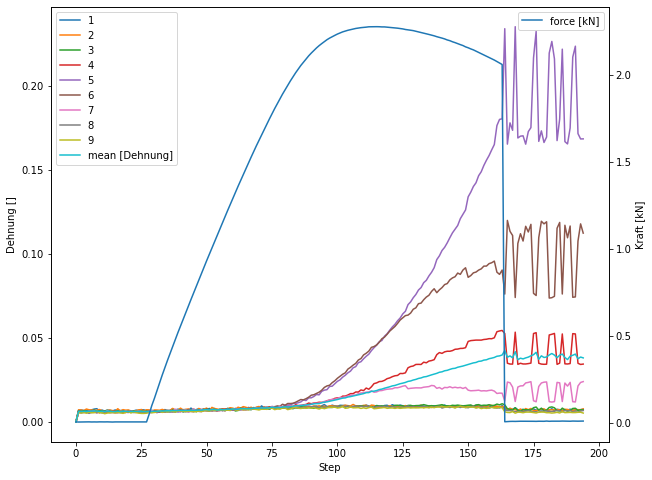

In [226]:
fig,ax=plt.subplots(figsize=(10,8))
ax1=ax.twinx()
for i in range(1,10):
    ax.plot(range(len(ap.index)),ap.iloc[:,i],label=i)
t=ax.plot(ap.mean(axis=1),label='mean [Dehnung]')


ax1.plot(force,label='force [kN]')
ax.legend()
ax1.legend()
ax1.set_ylabel('Kraft [kN]')
ax.set_ylabel('Dehnung []')
ax.set_xlabel('Step')
plt.show()
fig.savefig('test.png',dpi=500)

In [208]:

def get_full_df():
    return()

In [19]:
#######################################################################
#######################################################################
path='Y:\\Istra Repositories\\ch-gr_exports\\QL_A_8yiii.pickle'
lookup=pd.read_pickle(path,compression='zip')
display(lookup)


group                                                               add_data  \
dataset                                                      analog_channels   
Y:\Istra Repositories\ch-gr_exports\QL_A_8yiii\...  [[0.010035694995940606]]   
Y:\Istra Repositories\ch-gr_exports\QL_A_8yiii\...   [[0.00970689149003226]]   
Y:\Istra Repositories\ch-gr_exports\QL_A_8yiii\...  [[0.010035694995940606]]   
Y:\Istra Repositories\ch-gr_exports\QL_A_8yiii\...   [[0.00970689149003226]]   
Y:\Istra Repositories\ch-gr_exports\QL_A_8yiii\...  [[0.010364498501888794]]   
...                                                                      ...   
Y:\Istra Repositories\ch-gr_exports\QL_A_8yiii\...      [[3.92445087872521]]   
Y:\Istra Repositories\ch-gr_exports\QL_A_8yiii\...    [[3.9047225403645234]]   
Y:\Istra Repositories\ch-gr_exports\QL_A_8yiii\...    [[3.8340293372924235]]   
Y:\Istra Repositories\ch-gr_exports\QL_A_8yiii\...     [[3.790955811381801]]   
Y:\Istra Repositories\ch-gr_exports\QL_A_8yiii\...  [[0.006747659938646899]]   

group                                                                                     coordinates  \
dataset                                                                                  coordinate_x   
Y:\Istra Repositories\ch-gr_exports\QL_A_8yiii\...  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
Y:\Istra Repositories\ch-gr_exports\QL_A_8yiii\...  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
Y:\Istra Repositories\ch-gr_exports\QL_A_8yiii\...  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
Y:\Istra Repositories\ch-gr_exports\QL_A_8yiii\...  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
Y:\Istra Repositories\ch-gr_exports\QL_A_8yiii\...  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
...                                                                                               ...   
Y:\Istra Repositories\ch-gr_exports\QL_A_8yiii\...  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
Y:\Istra Repositories\ch-gr_exports\QL_A_8yiii\...  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
Y:\Istra Repositories\ch-gr_exports\QL_A_8yiii\...  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
Y:\Istra Repositories\ch-gr_exports\QL_A_8yiii\...  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
Y:\Istra Repositories\ch-gr_exports\QL_A_8yiii\...  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   

group                                                                                                  \
dataset                                                                              coordinate_x_var   
Y:\Istra Repositories\ch-gr_exports\QL_A_8yiii\...  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
Y:\Istra Repositories\ch-gr_exports\QL_A_8yiii\...  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
Y:\Istra Repositories\ch-gr_exports\QL_A_8yiii\...  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
Y:\Istra Repositories\ch-gr_exports\QL_A_8yiii\...  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
Y:\Istra Repositories\ch-gr_exports\QL_A_8yiii\...  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
...                                                                                               ...   
Y:\Istra Repositories\ch-gr_exports\QL_A_8yiii\...  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
Y:\Istra Repositories\ch-gr_exports\QL_A_8yiii\...  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
Y:\Istra Repositories\ch-gr_exports\QL_A_8yiii\...  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
Y:\Istra Repositories\ch-gr_exports\QL_A_8yiii\...  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
Y:\Istra Repositories\ch-gr_exports\QL_A_8yiii\...  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   

group                                                                                                  \
dataset                                                                                  coordinate_y   
Y:\Istra Reposito

MultiIndex([(     'add_data',             'analog_channels'),
            (  'coordinates',                'coordinate_x'),
            (  'coordinates',            'coordinate_x_var'),
            (  'coordinates',                'coordinate_y'),
            (  'coordinates',            'coordinate_y_var'),
            (  'coordinates',                'coordinate_z'),
            (  'coordinates',            'coordinate_z_var'),
            (  'coordinates',           'distance_to_plane'),
            (  'coordinates',          'distance_to_sphere'),
            (  'coordinates',                        'mask'),
            (  'coordinates',             'variance_sphere'),
            ('displacements',          'displacement_total'),
            ('displacements',     'displacement_total_rbmr'),
            ('displacements', 'displacement_total_rbmr_var'),
            ('displacements',      'displacement_total_var'),
            ('displacements',              'displacement_x'),
        

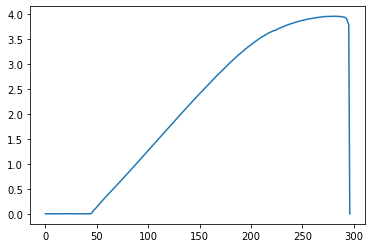

In [20]:
display(lookup.columns)
force=[]
for i in lookup.index:
    force.append(lookup.loc[i,('add_data','analog_channels')][0][0])

plt.plot(force)

(50, 163)

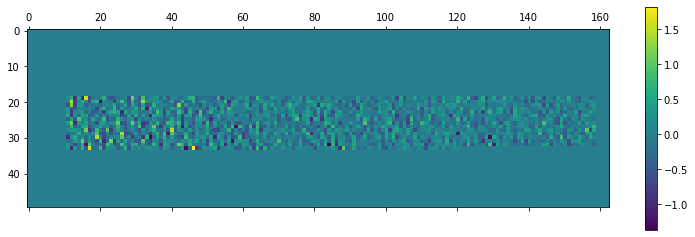

0.0017565757

In [21]:
strain=(      'strains',               'strain_yy')
array=lookup.loc['Y:\Istra Repositories\ch-gr_exports\QL_A_8yiii\series_step_1.hdf5',
                       strain]*100

display(array.shape)
a=plt.matshow(array)
#plt.scatter(46,33)
plt.colorbar(a)
plt.show()
display(np.mean(array))

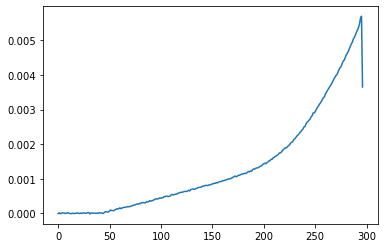

In [22]:
mean_strain=[]
for i in lookup.index:
    mean_strain.append(np.mean(lookup.loc[i,strain]))
plt.plot(mean_strain)
plt.show()

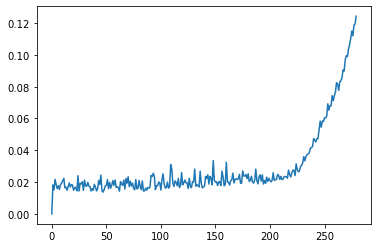

In [23]:
mean_strain=[]
for i in lookup.index[0:280]:
    mean_strain.append(np.max(lookup.loc[i,strain]))
plt.plot(mean_strain)

In [24]:
from scipy.signal import savgol_filter as sav
clean=sav(mean_strain,33,3,0,0)

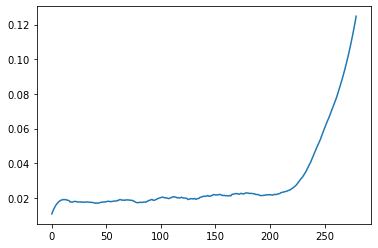

In [25]:
plt.plot(clean)

In [26]:
random_pixel_timeplot=[]
for i in lookup.index[0:280]:
    random_pixel_timeplot.append(lookup.loc[i,strain][33,46])
random_pixel_timeplot2=[]
for i in lookup.index[0:280]:
    random_pixel_timeplot2.append(lookup.loc[i,strain][33,49])

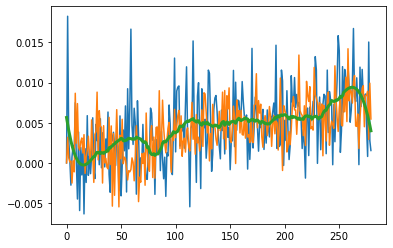

In [27]:
#display(random_pixel_timeplot)
plt.plot(random_pixel_timeplot)
plt.plot(random_pixel_timeplot2)
plt.plot(sav(random_pixel_timeplot,51,3,0,0),lw=3)
random_pixel_timeplot_clean=sav(random_pixel_timeplot,51,3,0,0)

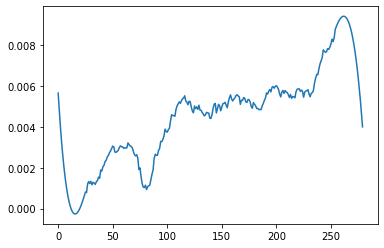

In [28]:
for num,i in enumerate(lookup.index[0:280]):
    lookup.loc[i,strain][33,46]=random_pixel_timeplot_clean[num]

random_pixel_timeplot_sclean=[]
for i in lookup.index[0:280]:
    random_pixel_timeplot_sclean.append(lookup.loc[i,strain][33,46])
plt.plot(random_pixel_timeplot_sclean)

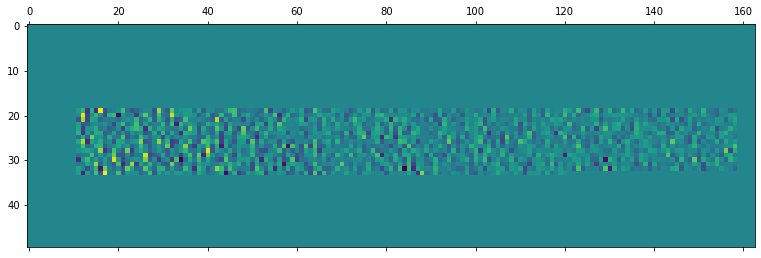

In [29]:
array=lookup.loc['Y:\Istra Repositories\ch-gr_exports\QL_A_8yiii\series_step_1.hdf5',
                       strain]*100
plt.matshow(array)

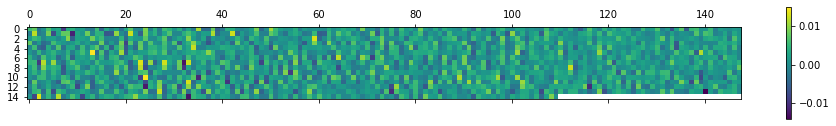

In [45]:
def get_df_mask(array:np.ndarray)->pd.DataFrame:
    df=pd.DataFrame(array)
    after=df.copy()
    after[after==0.]=np.nan
    after=np.divide(after,after)
    return(after)
def mask_df(df:np.ndarray,mask:np.ndarray)-> pd.DataFrame:
    after=np.multiply(df,mask)
    after=pd.DataFrame(after)
    after.dropna(how='all',axis=0,inplace=True)
    after.dropna(how='all',axis=1,inplace=True)
    return(after)
mask=get_df_mask(lookup.loc['Y:\Istra Repositories\ch-gr_exports\QL_A_8yiii\series_step_1.hdf5',
                       (      'strains',                   'strain_p1')])
p1_series=lookup.loc[:,strain].copy()
for i in p1_series.index:
    p1_series[i]=mask_df(p1_series[i],mask)
plt.matshow(p1_series[100])
plt.colorbar()

2220 297


,0,1,2,3,4,5,6,7,8,9,...,287,288,289,290,291,292,293,294,295,296
0,0.000000e+00,0.002822,0.001338,0.000533,0.005196,0.003281,0.012366,0.005232,0.003415,0.004692,...,0.008602,0.006194,0.000078,0.007217,0.008042,0.012267,0.006804,0.009797,0.004448,-0.000804
1,0.000000e+00,0.005989,0.002093,-0.000089,0.005803,0.008608,0.000663,0.004989,-0.001784,0.011004,...,0.010428,0.011805,0.011193,0.011793,0.019270,0.010887,0.007401,0.011414,0.018377,0.006805
2,0.000000e+00,-0.008799,-0.007139,0.002292,-0.014440,-0.005399,-0.004398,-0.005301,-0.005314,-0.007965,...,0.008318,-0.001606,0.007915,-0.001282,-0.002019,-0.001873,0.001147,0.002218,0.006684,-0.000787
3,0.000000e+00,0.005009,0.001385,-0.004853,0.010915,-0.002063,0.008473,0.002691,0.010682,-0.001380,...,0.009136,0.007643,0.009085,0.011529,0.009808,0.009294,0.008023,0.010485,0.005564,0.010260
4,5.960464e-08,-0.009355,0.002132,0.008429,-0.006865,-0.001743,-0.007491,-0.005459,0.000994,-0.001660,...,0.006169,0.007143,0.001847,0.008917,0.006933,-0.000401,0.005543,0.003676,0.004968,0.002333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2215,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2216,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2217,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2218,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


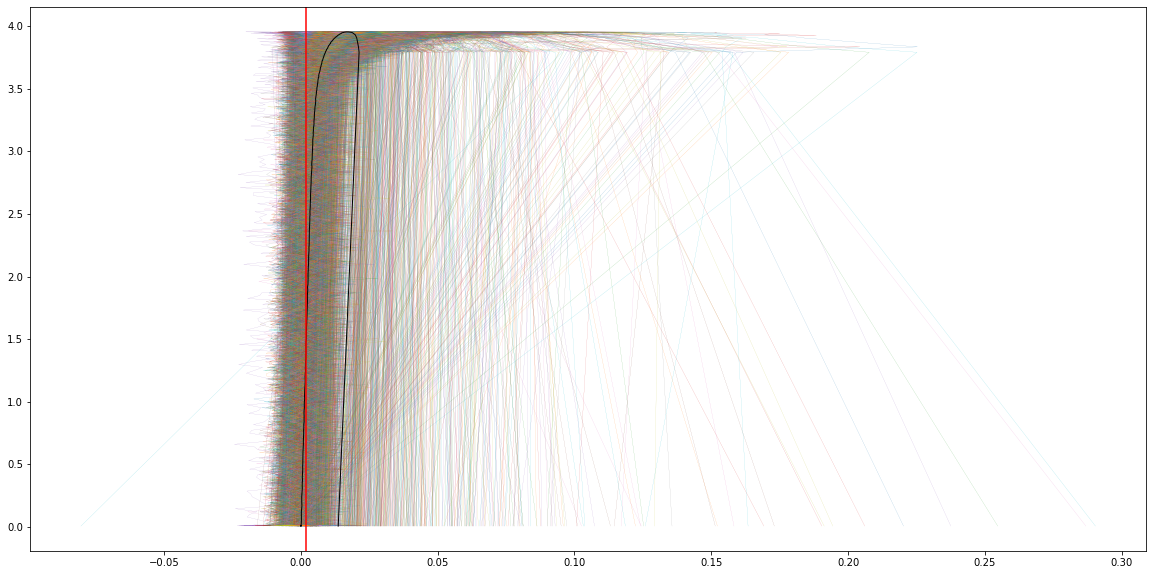

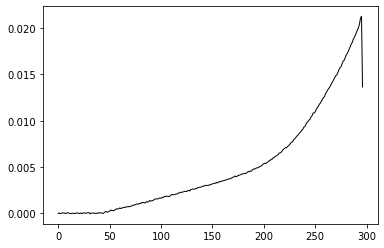

In [46]:
index=p1_series[0].shape[0]*p1_series[0].shape[1]
columns=p1_series.shape[0]
print(index,columns)
cleanup_df=pd.DataFrame(index=range(index),columns=range(columns))
for col in cleanup_df.columns:
    cleanup_df.loc[:,col]=np.array(p1_series[col]).flatten()
    #print(np.array(p1_series[col]).flatten().shape)
display(cleanup_df)
fig,ax=plt.subplots(figsize=(20,10))
for i in cleanup_df.index:
    ax.plot(cleanup_df.loc[i,:],force,lw=0.1)

mean_vector=[np.mean(cleanup_df.loc[:,x]) for x in cleanup_df.columns]
ax.plot(mean_vector,force,lw=1,c='k')
ax.axvline(x=0.002, color='r', linestyle='-')
plt.show()
plt.plot(mean_vector,lw=1,c='k')
plt.show()

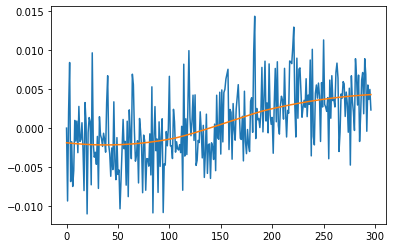

In [47]:
cleanup_df.fillna(0,inplace=True)
plt.plot(cleanup_df.iloc[4,:])
for i in cleanup_df.index:
    cleanup_df.loc[i,:]=sav((cleanup_df.loc[i,:]),211,2,0,0)
    cleanup_df.loc[i,:]=sav((cleanup_df.loc[i,:]),211,2,0,0)
    cleanup_df.loc[i,:]=sav((cleanup_df.loc[i,:]),211,2,0,0)
plt.plot(cleanup_df.iloc[4,:])

In [48]:
for num,i in enumerate(p1_series.index):
    p1_series[i]=np.array(cleanup_df.loc[:,num]).reshape(p1_series[i].shape)

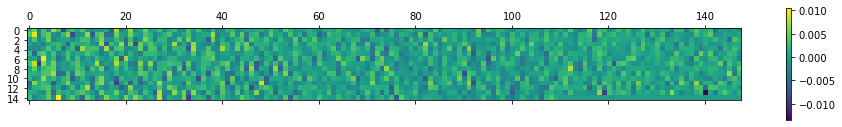

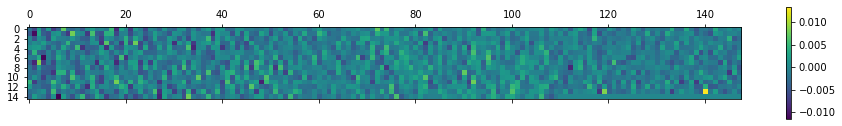

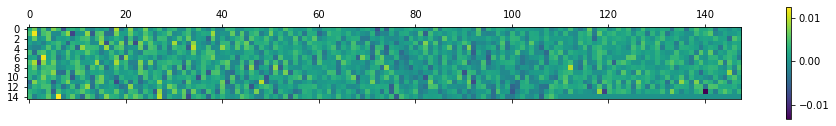

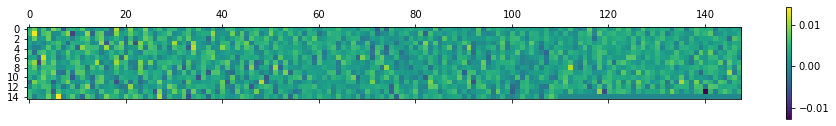

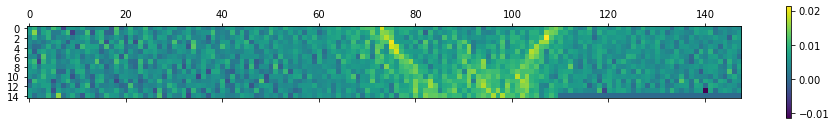

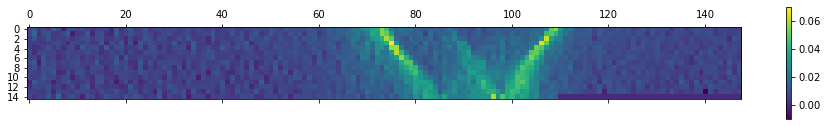

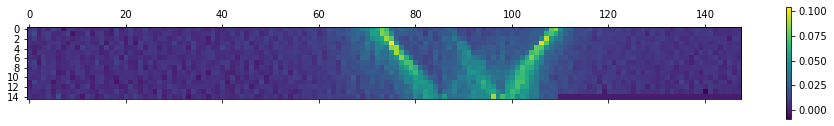

In [49]:
import plotly.express as px
fig=px.imshow(p1_series[250], color_continuous_scale='viridis')
fig.show()
plt.matshow(p1_series[50])
plt.colorbar()
plt.show()
window_min=-0.005
window_max=0.005
"""p1_arr=np.array(p1_series)
arr=p1_arr
arr[arr<window_min]=window_min
arr[arr>window_max]=window_max"""
plt.matshow(-1*p1_series[75],cmap='viridis')
plt.colorbar()
plt.show()
#plt.matshow(arr,cmap='viridis')
#plt.colorbar()
plt.show()
plt.matshow(p1_series[100])
plt.colorbar()
plt.show()
plt.matshow(p1_series[150])
plt.colorbar()
plt.show()
plt.matshow(p1_series[200])
plt.colorbar()
plt.show()
plt.matshow(p1_series[250])
plt.colorbar()
plt.show()
plt.matshow(p1_series[275])
plt.colorbar()
plt.show()

In [50]:
#plt.matshow(lookup.loc['Y:\Istra Repositories\ch-gr_exports\QL_A_8yiii\series_step_100.hdf5',
             #(  'coordinates',            'coordinate_y')])
p2=p1_series

In [51]:
a = p1_series[100]
n = 5
larger=(np.kron(a, np.ones((n,n))))

(75, 740)

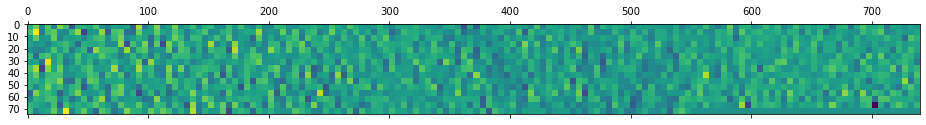

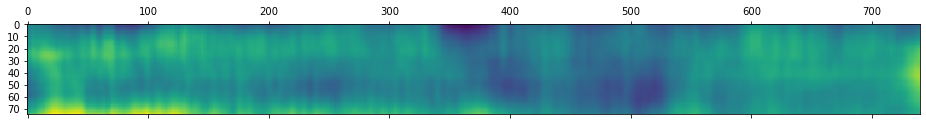

In [52]:
cleansed=sgolay2d(larger,71,3)
display(cleansed.shape)
plt.matshow(larger)
plt.show()
plt.matshow(cleansed)

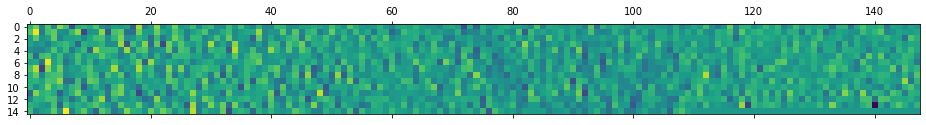

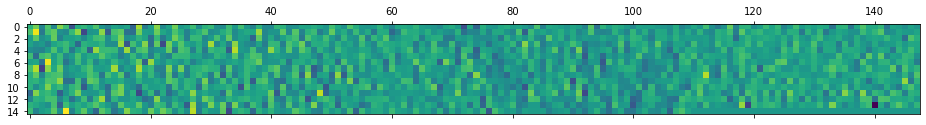

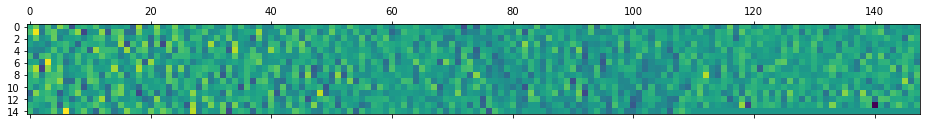

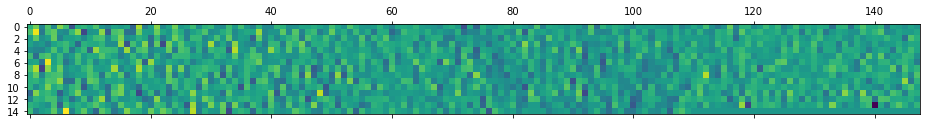

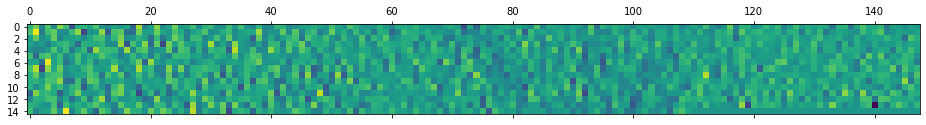

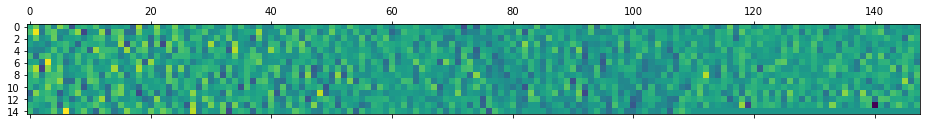

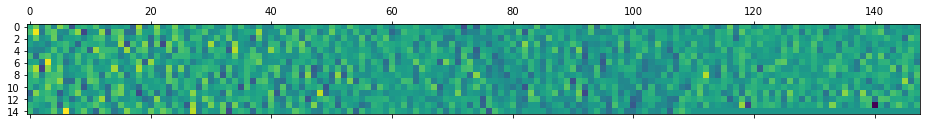

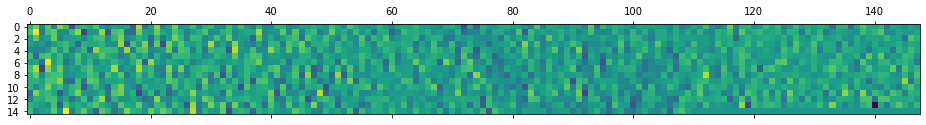

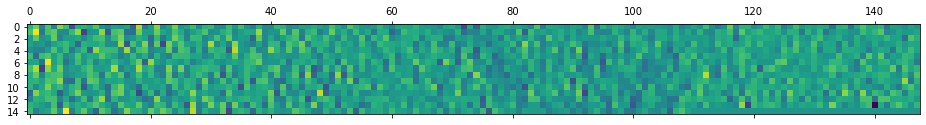

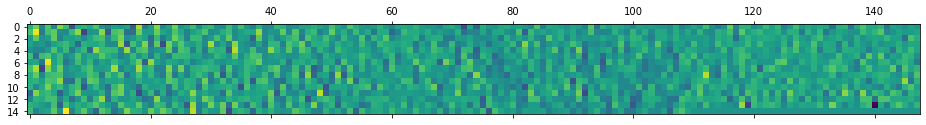

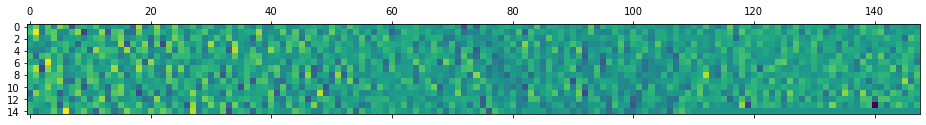

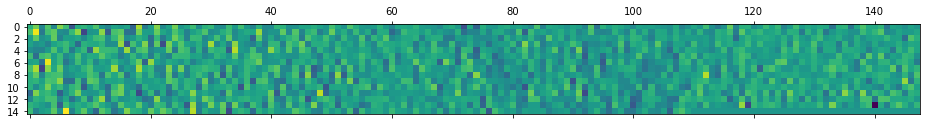

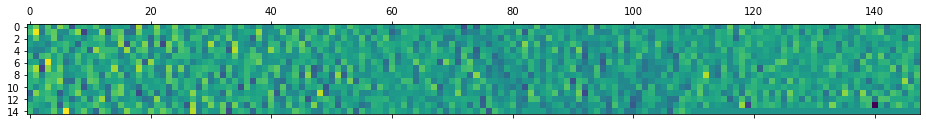

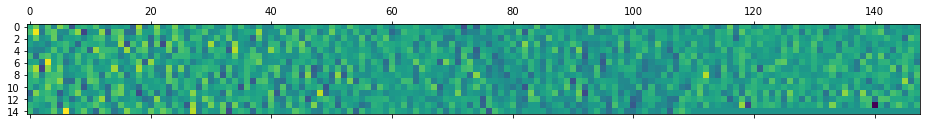

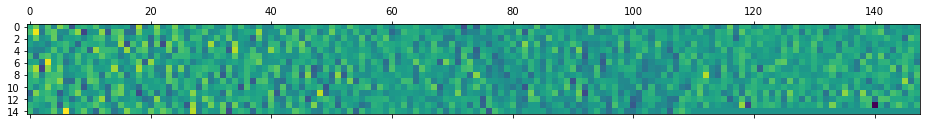

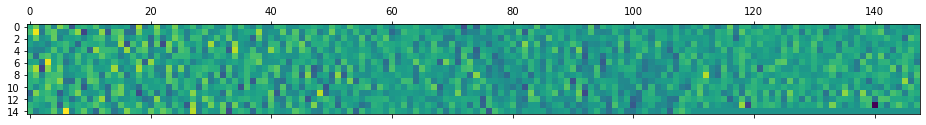

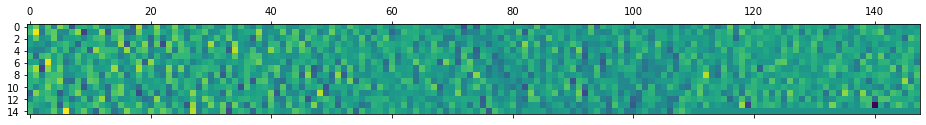

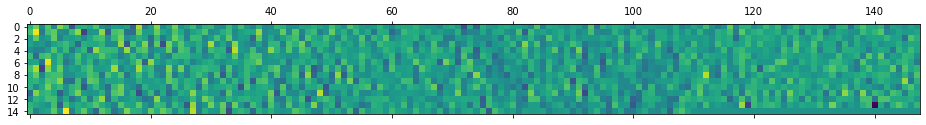

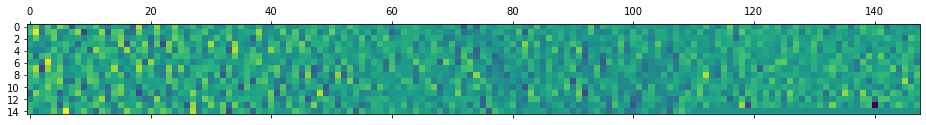

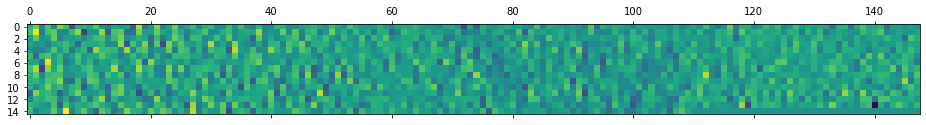

In [53]:
seq=np.array(p1_series[80:100])
for arr in seq:
    plt.matshow(arr)
    plt.show()

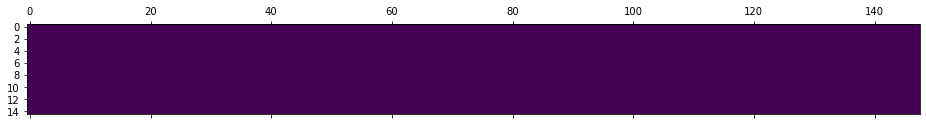

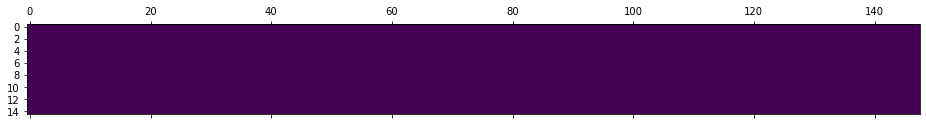

In [54]:
seq = [np.uint8(np.clip(i,0,255)) for i in seq]
plt.matshow(seq[11])
import cv2
dst = cv2.fastNlMeansDenoisingMulti(seq, 11, 11, None, 5, 7, 35)
plt.matshow(dst)

In [55]:
size=len(p1_series)
p1_arr=np.stack(p1_series.values)
display(p1_arr)
max_val=np.max(p1_arr.flatten().flatten())
min_val=np.min(p1_arr.flatten().flatten())
print(max_val,min_val,size)
print(p1_arr.shape)

array([[[ 0.00180378,  0.00321247, -0.00558358, ..., -0.00255057,
         -0.00056082, -0.00225706],
        [ 0.00300257,  0.0070652 , -0.00415975, ...,  0.00018015,
         -0.00134531,  0.00029358],
        [-0.0014985 ,  0.00155895, -0.0029544 , ..., -0.00421327,
          0.00237292,  0.0015782 ],
        ...,
        [-0.00482898, -0.00070193,  0.00168511, ..., -0.00066758,
          0.00086197, -0.00229459],
        [-0.00092721, -0.00038768, -0.00333915, ..., -0.00055565,
         -0.00172955, -0.00070585],
        [ 0.00141021, -0.00266833, -0.00174955, ...,  0.        ,
          0.        ,  0.        ]],

       [[ 0.00180632,  0.00325371, -0.00553603, ..., -0.00253456,
         -0.00054692, -0.0022374 ],
        [ 0.00302211,  0.00711979, -0.00415407, ...,  0.00017361,
         -0.00132928,  0.00029626],
        [-0.00147322,  0.00161142, -0.00292821, ..., -0.00422225,
          0.00240139,  0.00157857],
        ...,
        [-0.00478956, -0.00065266,  0.00168402, ..., -

0.13866436 -0.013446181 297
(297, 15, 148)


In [56]:
packs=[]
selector_df=pd.DataFrame(index=range(size+1))
for i in range(size+1):
    pack=[]
    runner=i-5
    while runner < i+6:
        if runner < 0:
            pack.append(0)
            runner+=1

        else:
            pack.append(runner)
            runner+=1
    packs.append(pack)
packs=np.array(packs)
packs[packs>=size]=size-1
display(packs
        )
selector_df['packs']=packs.tolist()
display(selector_df)

array([[  0,   0,   0, ...,   3,   4,   5],
       [  0,   0,   0, ...,   4,   5,   6],
       [  0,   0,   0, ...,   5,   6,   7],
       ...,
       [290, 291, 292, ..., 296, 296, 296],
       [291, 292, 293, ..., 296, 296, 296],
       [292, 293, 294, ..., 296, 296, 296]])

,packs
0,"[0, 0, 0, 0, 0, 0, 1, 2, 3, 4, 5]"
1,"[0, 0, 0, 0, 0, 1, 2, 3, 4, 5, 6]"
2,"[0, 0, 0, 0, 1, 2, 3, 4, 5, 6, 7]"
3,"[0, 0, 0, 1, 2, 3, 4, 5, 6, 7, 8]"
4,"[0, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9]"
...,...
293,"[288, 289, 290, 291, 292, 293, 294, 295, 296, ..."
294,"[289, 290, 291, 292, 293, 294, 295, 296, 296, ..."
295,"[290, 291, 292, 293, 294, 295, 296, 296, 296, ..."
296,"[291, 292, 293, 294, 295, 296, 296, 296, 296, ..."


In [57]:
collector=[]
for i in selector_df.index:
    data=[]
    for x in selector_df.loc[i,'packs']:
        data.append(p1_arr[x])
    collector.append(data)
selector_df['data_windows']=collector
display(selector_df)


,packs,data_windows
0,"[0, 0, 0, 0, 0, 0, 1, 2, 3, 4, 5]","[[[0.0018037762, 0.003212468, -0.0055835815, 0..."
1,"[0, 0, 0, 0, 0, 1, 2, 3, 4, 5, 6]","[[[0.0018037762, 0.003212468, -0.0055835815, 0..."
2,"[0, 0, 0, 0, 1, 2, 3, 4, 5, 6, 7]","[[[0.0018037762, 0.003212468, -0.0055835815, 0..."
3,"[0, 0, 0, 1, 2, 3, 4, 5, 6, 7, 8]","[[[0.0018037762, 0.003212468, -0.0055835815, 0..."
4,"[0, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9]","[[[0.0018037762, 0.003212468, -0.0055835815, 0..."
...,...,...
293,"[288, 289, 290, 291, 292, 293, 294, 295, 296, ...","[[[0.0073334156, 0.012446664, 0.0033484166, 0...."
294,"[289, 290, 291, 292, 293, 294, 295, 296, 296, ...","[[[0.0073421854, 0.012480688, 0.0033509892, 0...."
295,"[290, 291, 292, 293, 294, 295, 296, 296, 296, ...","[[[0.007350796, 0.012514761, 0.003353327, 0.00..."
296,"[291, 292, 293, 294, 295, 296, 296, 296, 296, ...","[[[0.007359247, 0.012548883, 0.0033554302, 0.0..."


,packs,data_windows,min,max,delta,step
0,"[0, 0, 0, 0, 0, 0, 1, 2, 3, 4, 5]","[[[0.0018037762, 0.003212468, -0.0055835815, 0...",-0.013285,0.008514,0.021799,0.000085
1,"[0, 0, 0, 0, 0, 1, 2, 3, 4, 5, 6]","[[[0.0018037762, 0.003212468, -0.0055835815, 0...",-0.013292,0.008559,0.021851,0.000085
2,"[0, 0, 0, 0, 1, 2, 3, 4, 5, 6, 7]","[[[0.0018037762, 0.003212468, -0.0055835815, 0...",-0.013299,0.008604,0.021904,0.000086
3,"[0, 0, 0, 1, 2, 3, 4, 5, 6, 7, 8]","[[[0.0018037762, 0.003212468, -0.0055835815, 0...",-0.013306,0.008649,0.021956,0.000086
4,"[0, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9]","[[[0.0018037762, 0.003212468, -0.0055835815, 0...",-0.013313,0.008694,0.022008,0.000086
5,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","[[[0.0018037762, 0.003212468, -0.0055835815, 0...",-0.013320,0.008739,0.022059,0.000086
6,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]","[[[0.0018063171, 0.003253712, -0.0055360305, 0...",-0.013326,0.008784,0.022110,0.000086
7,"[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]","[[[0.0018090518, 0.00329486, -0.005488561, 0.0...",-0.013333,0.008829,0.022162,0.000087
8,"[3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]","[[[0.0018119805, 0.003335912, -0.0054411734, 0...",-0.013339,0.008874,0.022212,0.000087
9,"[4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]","[[[0.0018151031, 0.0033768679, -0.005393867, 0...",-0.013345,0.008918,0.022263,0.000087


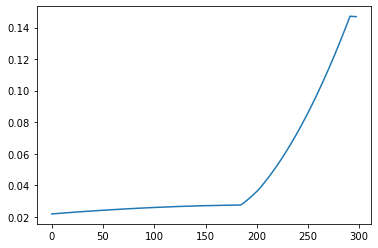

In [58]:
selector_df['min']=selector_df['data_windows'].apply(np.min)
selector_df['max']=selector_df['data_windows'].apply(np.max)
selector_df['delta']=selector_df['max']-selector_df['min']
selector_df['step']=selector_df.delta/256
display(selector_df.head(10))
plt.plot(selector_df.delta)

In [59]:
testrange=np.linspace(selector_df.loc[0,'min'],selector_df.loc[0,'max'],45)
display(np.around(((testrange+abs(selector_df.loc[0,'min']))/selector_df.loc[0,'delta'])*255,decimals=0))

array([  0.,   6.,  12.,  17.,  23.,  29.,  35.,  41.,  46.,  52.,  58.,
        64.,  70.,  75.,  81.,  87.,  93.,  99., 104., 110., 116., 122.,
       128., 133., 139., 145., 151., 156., 162., 168., 174., 180., 185.,
       191., 197., 203., 209., 214., 220., 226., 232., 238., 243., 249.,
       255.])

(11, 15, 148)

(24420,)

(11, 15, 148)

24420

array([[[156., 156., 154., ..., 154., 155., 155.],
        [156., 157., 154., ..., 155., 155., 155.],
        [155., 156., 154., ..., 154., 156., 156.],
        ...,
        [154., 155., 156., ..., 155., 155., 155.],
        [155., 155., 154., ..., 155., 155., 155.],
        [155., 154., 155., ..., 155., 155., 155.]],

       [[156., 156., 154., ..., 154., 155., 155.],
        [156., 157., 154., ..., 155., 155., 155.],
        [155., 156., 154., ..., 154., 156., 156.],
        ...,
        [154., 155., 156., ..., 155., 155., 155.],
        [155., 155., 154., ..., 155., 155., 155.],
        [155., 154., 155., ..., 155., 155., 155.]],

       [[156., 156., 154., ..., 154., 155., 155.],
        [156., 157., 154., ..., 155., 155., 155.],
        [155., 156., 154., ..., 154., 156., 156.],
        ...,
        [154., 155., 156., ..., 155., 155., 155.],
        [155., 155., 154., ..., 155., 155., 155.],
        [155., 154., 155., ..., 155., 155., 155.]],

       ...,

       [[156., 156., 154

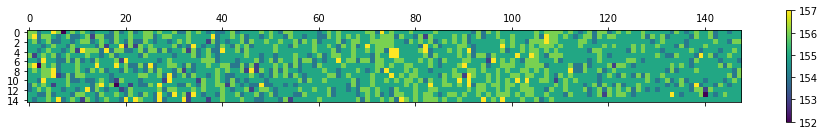

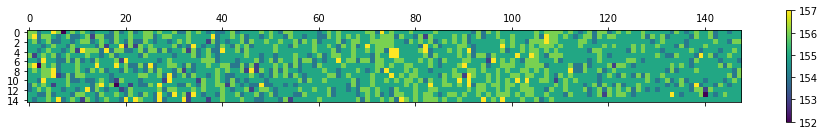

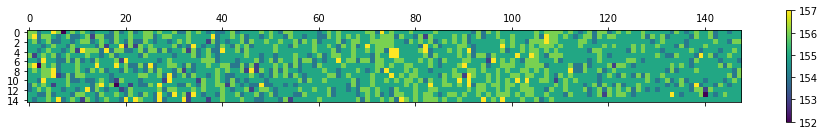

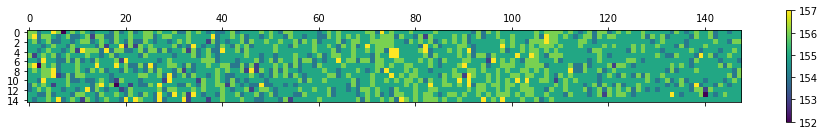

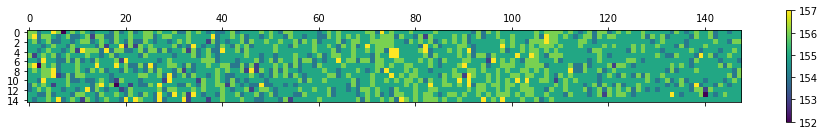

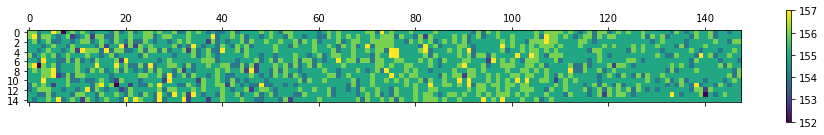

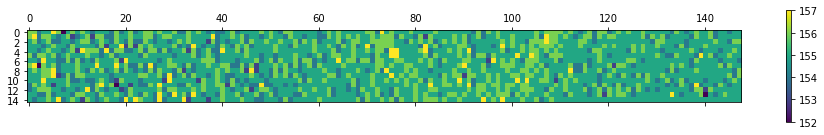

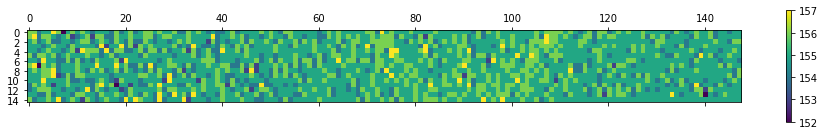

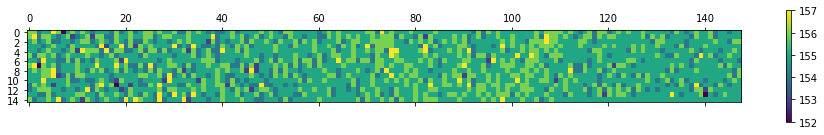

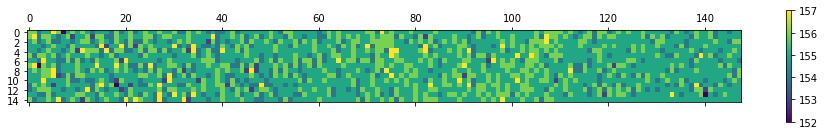

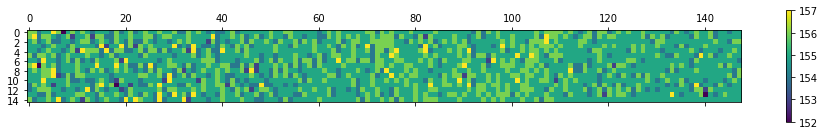

In [60]:
def prod(x:tuple):
    run=1
    for i in x:
        run=i*run
    return run



testar=np.array(selector_df.loc[1,'data_windows'])
sh=prod(np.array(selector_df.loc[1,'data_windows']).shape)
flatar=np.reshape(testar,(sh))
miin=selector_df.loc[1,'min']
deelta=selector_df.loc[1,'delta']
for i,val in enumerate(flatar):
    flatar[i]=np.around((val+abs(miin)/deelta)*255,decimals=0)
retar=np.reshape(flatar,testar.shape)
display(testar.shape,flatar.shape,retar.shape)
display(prod(np.array(selector_df.loc[1,'data_windows']).shape))
display(retar)
for i in range(len(retar)):
    plt.matshow(retar[i])
    plt.colorbar()